# 18.335 Final Project Code

In [17]:
import numpy as np
from scipy.linalg import lu, solve_triangular
from lib import load_linear_program
from functools import reduce
import matplotlib.pyplot as plt

GLOBAL_TOLERANCE = 1e-15

In [18]:
def update_inverse(B_inv, u, v):
    """
    Updates the inverse of a the input B_inv using the vector uv.add(
        
    Follows the Sherman-Morrison Updates Rules with the form
    
    B_inv_new = B_inv + uv.T
    )
    
    returns the new B_inv
    """
    return B_inv  - ((B_inv @ u @ v.T @ B_inv)/(1+v.T@B_inv@u)), (1+v.T@B_inv@u).item()

def update_inverse_d(B_inv, u, v, d_p, d):
    """
    Updates the inverse of a the input B_inv using the vector uv.add(
        
    Follows the Sherman-Morrison Updates Rules with the form
    
    B_inv_new = B_inv + uv.T
    )
    
    uses a simplified version of the formula given what guarantees about
    B_inv, u, and v we can assume given the algorithm being used and given that
    B_inv @ a_j = d
    
    and v.T@d = d_p
    returns the new B_inv
    """
    return B_inv  - (((d - v) @ v.T @ B_inv)/(d_p)), (d_p).item()

def apply_r_inverses(r_inv_tracker, v, reverse=False):
    """
    Used in the Forrest–Tomlin update
    
    
    r_inv_tracker is a python array holding [R_1_inv, R_2_inv, ..., R_k_inv]
    
    Multiplies the input vector/matrix v on the right
    
    If reverse is False,
        returns R_k_inv @ ... @ R_1_inv @ v
    else
        returns R_1_inv @ ... @ R_k_inv @ v
    
    """
    curr = v.copy()
    r_inv_tracker = r_inv_tracker if not reverse else reversed(r_inv_tracker)
    for R in r_inv_tracker:
        curr = R @ curr
    return curr

def update_lu(P, L, U, leaving_idx, entering_col, r_inv_tracker):
    """
    Updates A = PLU decomposition with entering column and index
        of leaving variable
        
    returns P, L, r_inv_tracker, U_new
    
    mutates the r_inv_tracker passed in
    
    Follows the Forrest-Tomlin update outlined in "Novel update techniques for the revised simplex method"
        by Qi Huangfu and J.A. Julian Hall
        
    returns P, L, r_inv_tracker, U_new
    """
    a_tilde = solve_triangular(L, P.T @ entering_col, lower=True, unit_diagonal=True)
    a_tilde = apply_r_inverses(r_inv_tracker, a_tilde)
    
    e_p = np.zeros((U.shape[1], 1))
    e_p[leaving_idx, 0] = 1
    
    U_prime = U + (a_tilde - U[:, leaving_idx].reshape((-1, 1))) @ e_p.T
    
    e_tilde_p = np.linalg.solve(U.T, e_p)
    r_transpose = e_p.T - U[leaving_idx, leaving_idx] * e_tilde_p.T
    R_inv = np.eye(*L.shape) - e_p @ r_transpose
    r_inv_tracker.append(R_inv)
    
    U_new = R_inv @ U_prime
    
    return P, L, r_inv_tracker, U_new    

def is_upper_triangular(A):
    
    return np.array_equal(A, np.triu(A))
def is_lower_triangular(A):
    
    return np.array_equal(A, np.tril(A))

def solve_from_PLU_transpose(P, L, U, r_inv_tracker, b):
    """
    Solves the linear system
    
    B.T x = b
    
    where 
    
    B = P @ L @ R_1 @ ... @ R_k @ U
    
    U.T @ R_k.T @ ... @ R_1.T @ L.T @ P.T x = b
    
    returns x = P @ L.T^(-1) @ R_1.T^(1) @ ... @ R_k^(-1) @ U^(-1) @ b
    """
    z = np.linalg.solve(U.T, b)
    z_prime = apply_r_inverses([r.T for r in r_inv_tracker], z, reverse=True)
    y = solve_triangular(L.T, z_prime)
    x = P @ y
    return x

def solve_from_PLU(P, L, U, r_inv_tracker, b):
    """
        Solves the linear system
    
    B x = b
    
    where 
    
    B = P@L@R_1@...@R_k@U
    
    P @ L @ R_1 @ ... @ R_k @ U @ x = b
    
    returns x = U^(-1) @ R_k ^(-1) @ ... @ R_1 ^(-1) @ L^(-1) @ P.T b
    """
    y = solve_triangular(L, P.T @ b, lower=True)
    y_prime = apply_r_inverses(r_inv_tracker, y)
    x = np.linalg.solve(U, y_prime)
    return x


In [19]:
def build_phase_one_matrix(A_in, b_in, types):
    """
    Builds phase one simplex matrix
    
    Adds slack variables and artificial variables as needed
    
    returns A_total, b_phase1, C_phase1, basis, non_basis, slack_start, slack_end, art_indicies, origin_n
    """
    m, n = A.shape
    
    rows = []
    rhs = []
    row_types = []
    
    for i, t in enumerate(types):
        if t == "L":
            rows.append((A[i,:].copy()))
            rhs.append(b[i,:])
            row_types.append("L")
        elif t == "G":
            rows.append((-A[i,:].copy()))
            rhs.append(-b[i,:])
            row_types.append("L")
        elif t == "E":
            rows.append((A[i,:].copy()))
            rhs.append(b[i,:])
            row_types.append("L")
            
            rows.append((-A[i,:].copy()))
            rhs.append(-b[i,:])
            row_types.append("L")
        else:
            raise ValueError(f"Unkown type: {t}")
        
    A_phase1 = np.vstack(rows)
    b_phase1 = np.array(rhs).reshape((-1,1))
    m2 = A_phase1.shape[0]
    
    #Adds slack variables for all the constraints in order to turn everything into an equality instead of an inequality
    slack_vars = np.eye(m2)
    
    
    
    need_artificial = np.zeros(m2, dtype=bool)
    artificial_columns = []
    
    for i in range(m2):
        if b_phase1[i,0] < 0:
            """
            If the rhs for the constraint is negative, then we need to add an artificial variable
            
            We do this because in the simplex algorithm we start by setting the slack variables equal
                to the rhs. However the slack variables must obey a non-negativity constraint. So if
                the rhs is negative, that will yield an unfeasible solution. 
            """
            A_phase1[i, :] = -A_phase1[i, :] 
            b_phase1[i, :] = -b_phase1[i, :]
            slack_vars[i,i] = -slack_vars[i,i]
            need_artificial[i] = True
           
           #adds the artificial column to a list of artificial columns
            col = np.zeros((m2, 1))
            col[i, 0] = 1.0
            artificial_columns.append(col)
        else:
           need_artificial[i] = False
    
    
    art_indicies = []
    origin_n = n
    
    """
    Our simplex constraint matrix will always be structured in the block form
    [original_constraints, slack_variables, artificial_variables]
    """
    if len(artificial_columns) > 0:
        A_total = np.hstack([A_phase1, slack_vars, np.hstack(artificial_columns)])
        art_start = origin_n + m2
        art_indicies = list(range(art_start, art_start + len(artificial_columns)))
    else:
        A_total = np.hstack([A_phase1, slack_vars])
        
        
    slack_start = origin_n
    slack_end = origin_n + m2
    basis = []
    
    
    reversed_artificial_indices = iter(art_indicies)
    
    #If there is an artificial variable, add that to the basis. Otherwise add the slack variable to the basis
    for i in range(m2):
        if need_artificial[i]:
            basis.append(next(reversed_artificial_indices))
        else:
            basis.append(origin_n + i)
    non_basis = [i for i in range(A_total.shape[1]) if i not in basis]
    
    # The objective function for the first phase will be the sum of the artificial variables
    # Our goal will be to find an assignment where the sum is zero.
    C_phase1 = np.zeros((A_total.shape[1], 1))
    for idx in art_indicies:
        C_phase1[idx, 0] = 1
    return A_total, b_phase1, C_phase1, basis, non_basis, slack_start, slack_end, art_indicies, origin_n
    

In [20]:

def pivot():
    pass
    
def revised_simplex_loop_inv(A_total, B_inv, X_b, basis, non_basis, c_total, phase, tolerance=GLOBAL_TOLERANCE, max_iter=100):
    """
    minimzation problem
    """
    
    m = A_total.shape[0]
    n = A_total.shape[1]
    n_total = A_total.shape[1]
    
    N = A_total[:, non_basis]
    C_b = c_total[basis, :].copy()
    C_n = c_total[non_basis, :].copy()
    errors = []
    objective_val = []
    denominators = []
    for i in range(max_iter):
        # print(f"{phase} ITERATION {i}")
        
        
        y = B_inv.T @ C_b
        reduced_costs = (C_n - (N.T @ y))
        
        rc = reduced_costs.ravel()
        
        x_total = np.zeros((n,1))
        for j, col in enumerate(basis):
            x_total[col,0] = X_b[j,0]
        optimal_val = (c_total.T @ x_total).item()
        objective_val.append(optimal_val)
        
        if np.all(rc >= -tolerance):
            
            print(f"Optimal found after {i+1} iterations")
            return B_inv, X_b, basis, non_basis, True, errors, objective_val, denominators
        
        
        #Find entering variable
        
        neg_indices = np.where(rc < -tolerance)[0]
        if neg_indices.size == 0:
            print(f"Optimal found after {i+1} iterations")
            return B_inv, X_b, basis, non_basis, True, errors, objective_val, denominators
        
        #By Blandcycling rule, we choose the entering variable to be the one with smallest index
        entering_var = min(neg_indices)
        entering_col = non_basis[entering_var]
        a_j = N[:, entering_var:entering_var+1]
        
        #Find direction
        d = B_inv @ a_j
        
        mask = (d > tolerance).flatten()
        
        if not np.any(mask):
            raise ValueError(f"{phase}: Unbounded along entering {entering_col}")
        
        
        #Find leaving var
        
        ratios = np.divide(X_b[mask], d[mask]).flatten()
        leaving_rows = np.arange(m)[mask].flatten()
        theta = np.min(ratios)
        # indices with the same minimum ratio within tolerance
        candidate_rows = leaving_rows[np.isclose(ratios, theta, atol=tolerance)]
        leaving_row = int(np.min(candidate_rows))  # smallest index tie-break
        leaving_col = basis[leaving_row]

        
        #Pivot
        basis[leaving_row], non_basis[entering_var] = non_basis[entering_var], basis[leaving_row]
        
        # Necessary to find u and v for the Sherman-Morrison update formula
        u = a_j - A_total[:, [leaving_col]]
        v = np.zeros((m, 1))
        v[leaving_row, 0] = 1
        B_inv, denom = update_inverse(B_inv, u, v)
        # B_inv, denom = update_inverse_d(B_inv, u, v, d[leaving_row], d)
        
        denominators.append(denom)
        # actual = np.linalg.inv(A_total[:, basis].copy())
        # errors.append(np.linalg.norm(B_inv - actual, ord='fro'))
        errors.append(np.linalg.norm(A_total[:, basis] @ B_inv - np.eye(*B_inv.shape), ord='fro'))
        
        #find objective val at this iteration

        # print(f"{phase} after iteration {i} Distance from actual inverse Frobenius: {=}")
        # print(f"{phase} after iteration {i} Distance from actual inverse 2-norm: {np.linalg.norm(B_inv - actual, ord=2)=}")
        
        X_b = X_b - d*theta
        X_b[leaving_row, 0] = theta
        N = A_total[:, non_basis].copy()
        C_b = c_total[basis].copy()
        C_n = c_total[non_basis].copy()
        
    #Print the unoptimal value that was found after reaching the max number of iterations
    x_total = np.zeros((n,1))
    for j, col in enumerate(basis):
        x_total[col,0] = X_b[j,0]
    optimal_val = (c_total.T @ x_total).item()
    print(f"{phase} after iteration {i} output\n{optimal_val=}")
        
    
    return B_inv, X_b, basis, non_basis, False, errors, objective_val, denominators

In [21]:

def pivot():
    pass
    
def revised_simplex_loop_lu(A_total, P, L, U, X_b, basis, non_basis, c_total, phase, tolerance=GLOBAL_TOLERANCE, max_iter=100):
    """
    minimzation problem
    """
    
    m = A_total.shape[0]
    n = A_total.shape[1]
    n_total = A_total.shape[1]
    
    N = A_total[:, non_basis]
    C_b = c_total[basis, :].copy()
    C_n = c_total[non_basis, :].copy()
    r_inv_tracker = []
    errors = []
    
    objective_val = []
    for i in range(max_iter):
        # print(f"LU {phase} ITERATION {i}")
        
        y = solve_from_PLU_transpose(P, L, U, r_inv_tracker, C_b)
        reduced_costs = (C_n - (N.T @ y))
        
        rc = reduced_costs.ravel()
        
        x_total = np.zeros((n,1))
        for j, col in enumerate(basis):
            x_total[col,0] = X_b[j,0]
        optimal_val = (c_total.T @ x_total).item()
        objective_val.append(optimal_val)
        
        if np.all(rc >= -tolerance):
            
            print(f"LU Optimal found after {i+1} iterations")
            return (P, L, r_inv_tracker, U), X_b, basis, non_basis, True, errors, objective_val
        
        
        #Find entering variable
        
        neg_indices = np.where(rc < -tolerance)[0]
        if neg_indices.size == 0:
            print(f"Optimal found after {i+1} iterations")
            return (P, L, r_inv_tracker, U), X_b, basis, non_basis, True, errors, objective_val
        
        #By Blandcycling rule, we choose the entering variable to be the one with smallest index
        entering_var = min(neg_indices)
        entering_col = non_basis[entering_var]
        a_j = N[:, entering_var:entering_var+1]
        
        #Find direction
        d = solve_from_PLU(P, L, U, r_inv_tracker, a_j)
        # d = B_inv @ a_j
        
        mask = (d > tolerance).flatten()
        
        if not np.any(mask):
            raise ValueError(f"LU {phase}: Unbounded along entering {entering_col}")
        
        
        #Find leaving var
        
        ratios = np.divide(X_b[mask], d[mask]).flatten()
        leaving_rows = np.arange(m)[mask].flatten()
        theta = np.min(ratios)
        # indices with the same minimum ratio within tolerance
        candidate_rows = leaving_rows[np.isclose(ratios, theta, atol=tolerance)]
        leaving_row = int(np.min(candidate_rows))  # smallest index tie-break
        leaving_col = basis[leaving_row]

        
        #Pivot
        basis[leaving_row], non_basis[entering_var] = non_basis[entering_var], basis[leaving_row]
        
        # Necessary to find u and v for the Sherman-Morrison update formula
        #update_lu(P, L, U, leaving_idx, entering_col, r_inv_tracker):
        
        P, L, r_inv_tracker, U = update_lu(P, L, U, leaving_row, a_j, r_inv_tracker)
        
        
        L_inv = np.linalg.inv(L)
        U_inv = np.linalg.inv(U)
        B_inv = U_inv @  apply_r_inverses(r_inv_tracker, L_inv @ P.T)
        # actual = np.linalg.inv(A_total[:, basis].copy())
        # errors.append(np.linalg.norm(B_inv - actual, ord='fro'))
        errors.append(np.linalg.norm(A_total[:, basis] @ B_inv - np.eye(*B_inv.shape), ord='fro'))
        

        
        # print(f"LU {phase} after iteration {i} Distance from actual inverse Frobenius: {=}")
        # print(f"LU {phase} after iteration {i} Distance from actual inverse 2-norm: {np.linalg.norm(B_inv - actual, ord=2)=}")
        
        X_b = X_b - d*theta
        X_b[leaving_row, 0] = theta
        N = A_total[:, non_basis].copy()
        C_b = c_total[basis].copy()
        C_n = c_total[non_basis].copy()
        
    #Print the unoptimal value that was found after reaching the max number of iterations
    x_total = np.zeros((n,1))
    for j, col in enumerate(basis):
        x_total[col,0] = X_b[j,0]
    optimal_val = (c_total.T @ x_total).item()
    print(f"LU {phase} after iteration {i} output\n{optimal_val=}")
        
    
    return (P, L, r_inv_tracker, U), X_b, basis, non_basis, False, errors, objective_val

In [22]:
def clean_phase_one_basis(A_total, B_inv, X_b, basis, non_basis,
                          artificial_indices, tolerance=GLOBAL_TOLERANCE):
    """
    Removes artificial variables from the basis after Phase I.
    Returns cleaned A_total, B_inv, X_b, basis, non_basis, c_total.
    """
    m, n = A_total.shape
    basis = np.array(basis)
    non_basis = np.array(non_basis)

    # Check feasibility of Phase 1 result
    if np.any(X_b < -tolerance):
        raise ValueError("Phase 1 ended with infeasible basic variables — problem infeasible.")
    artificial_indices_set = set(artificial_indices)
    # Find artificial indices that are still in the basis. They will need to be removed later
    art_in_basis = [idx for idx in basis if idx in artificial_indices_set]

    for art in art_in_basis:
        # row position in basis
        r = np.where(basis == art)[0][0]   

        # Try to find non-artificial, nonbasic column to pivot in
        for j in non_basis:
            
            # skip other artificials
            if j in artificial_indices_set:
                continue  
            a_j = A_total[:, [j]]
            u = B_inv @ a_j
            if abs(u[r, 0]) > tolerance:
                # Pivot j into the basis replacing art
                leaving_col = art
                basis[r] = j
                non_basis[non_basis == j] = leaving_col

                # Update inverse (rank-1 update)
                u_vec = a_j - A_total[:, [leaving_col]]
                v = np.zeros((m, 1))
                v[r, 0] = 1
                B_inv,_ = update_inverse(B_inv, u_vec, v)

                break
        else:
            # No replacement found means redundant constraint
            raise RuntimeError("No replacement found for a artificial variable")

    # Drop any remaining nonbasic artificial columns 
    keep_cols = [j for j in range(A_total.shape[1]) if j not in artificial_indices]
    A_total = A_total[:, keep_cols]
    basis = np.array([j for j in basis if j in keep_cols])
    non_basis = np.array([j for j in non_basis if j in keep_cols])

    # Return cleaned problem
    return A_total, X_b, basis, non_basis

def clean_phase_one_basis_lu(A_total, P, L,  r_inv_tracker, U, X_b, basis, non_basis,
                          artificial_indices, tolerance=GLOBAL_TOLERANCE):
    """
    Removes artificial variables from the basis after Phase I.
    Returns cleaned A_total, B_inv, X_b, basis, non_basis, c_total.
    """
    m, n = A_total.shape
    basis = np.array(basis)
    non_basis = np.array(non_basis)

    # Check feasibility of Phase 1 result
    if np.any(X_b < -tolerance):
        raise ValueError("Phase 1 ended with infeasible basic variables — problem infeasible.")
    artificial_indices_set = set(artificial_indices)
    # Find artificial indices that are still in the basis. They will need to be removed later
    art_in_basis = [idx for idx in basis if idx in artificial_indices_set]

    for art in art_in_basis:
        # row position in basis
        r = np.where(basis == art)[0][0]   

        # Try to find non-artificial, nonbasic column to pivot in
        for j in non_basis:
            
            # skip other artificials
            if j in artificial_indices_set:
                continue  
            a_j = A_total[:, [j]]
            #u = B_inv @ a_j
            u = solve_from_PLU(P, L, U, r_inv_tracker, a_j)
            if abs(u[r, 0]) > tolerance:
                # Pivot j into the basis replacing art
                leaving_col = art
                basis[r] = j
                non_basis[non_basis == j] = leaving_col

                P, L, r_inv_tracker, U = update_lu(P, L, U, r, a_j, r_inv_tracker)
                
                break
        else:
            # No replacement found means redundant constraint
            raise RuntimeError("No replacement found for a artificial variable")

    # Drop any remaining nonbasic artificial columns 
    keep_cols = [j for j in range(A_total.shape[1]) if j not in artificial_indices]
    A_total = A_total[:, keep_cols]
    basis = np.array([j for j in basis if j in keep_cols])
    non_basis = np.array([j for j in non_basis if j in keep_cols])

    # Return cleaned problem
    return A_total, X_b, basis, non_basis

In [23]:
def revised_simplex_two_phase_inv(A, b, c, types, tolerance=GLOBAL_TOLERANCE, max_iter=500, problem="max"):
    A_total, b_proc, c_phase1, basis, non_basis, slack_start, slack_end, art_indices, orig_n = build_phase_one_matrix(A,b,types)
    
    
    B_inv = np.linalg.inv(A_total[:, basis])
    X_b = b_proc.copy()
    
    B_inv, X_b, basis, non_basis, success, errors, objective, denoms = revised_simplex_loop_inv(A_total, B_inv, X_b, basis, non_basis, c_phase1, "phase 1", tolerance, max_iter)
    
    
    #Check Phase 1 Objective
    x_total = np.zeros((A_total.shape[1],1))
    x_total[basis,0] = X_b.ravel()
    obj_phase1 = (c_phase1.T @ x_total).item()
    if obj_phase1 > tolerance:
        raise ValueError(f"Infeasible LP: Phase I objective = {obj_phase1}")
    print()
    if art_indices:
        A_total, X_b, basis, non_basis =  clean_phase_one_basis(A_total, B_inv, X_b, basis, non_basis,
                          art_indices, tolerance=1e-10)
        B_inv = np.linalg.inv(A_total[:, basis])
        
    c_total = np.vstack([c, np.zeros((slack_end-slack_start, 1))])
    c_total_phase2 = c_total
        
        
    B_inv, X_b, basis, non_basis, success, errors, objective, denoms = revised_simplex_loop_inv(A_total, B_inv, X_b, basis, non_basis, c_total_phase2, "Phase 2", tolerance, max_iter)
    
    x_total = np.zeros((orig_n,1))
    for i, col in enumerate(basis):
        if col < orig_n:
            x_total[col,0] = X_b[i,0]
    optimal_val = (c_total_phase2[:orig_n].T @ x_total).item()
    if problem=="max":
        optimal_val = -optimal_val

    return x_total, optimal_val, errors, objective, denoms

def revised_simplex_two_phase_lu(A, b, c, types, tolerance=GLOBAL_TOLERANCE, max_iter=500, problem="max"):
    A_total, b_proc, c_phase1, basis, non_basis, slack_start, slack_end, art_indices, orig_n = build_phase_one_matrix(A,b,types)
    
    P, L, U = lu(A_total[:, basis])
    # B_inv = np.linalg.inv(A_total[:, basis])
    X_b = b_proc.copy()
    
    # B_inv, X_b, basis, non_basis, success = revised_simplex_loop_inv(A_total, B_inv, X_b, basis, non_basis, c_phase1, "phase 1", tolerance, max_iter)
    (P, L, r_inv_tracker, U), X_b, basis, non_basis, success, errors, objective = revised_simplex_loop_lu(A_total, P, L, U, X_b, basis, non_basis, c_phase1, "phase 1", tolerance, max_iter)
    
    #Check Phase 1 Objective
    x_total = np.zeros((A_total.shape[1],1))
    x_total[basis,0] = X_b.ravel()
    obj_phase1 = (c_phase1.T @ x_total).item()
    if obj_phase1 > tolerance:
        raise ValueError(f"Infeasible LP: Phase I objective = {obj_phase1}")
    print()
    if art_indices:
        A_total, X_b, basis, non_basis =  clean_phase_one_basis_lu(A_total, P, L, r_inv_tracker, U, X_b, basis, non_basis,
                          art_indices, tolerance=1e-10)
        # B_inv = np.linalg.inv(A_total[:, basis])
        
    c_total = np.vstack([c, np.zeros((slack_end-slack_start, 1))])
    c_total_phase2 = c_total
    
    P, L, U = lu(A_total[:, basis])
    #revised_simplex_loop_lu(A_total, P, L, U, X_b, basis, non_basis, c_total, phase, tolerance=GLOBAL_TOLERANCE, max_iter=100):
        
    (P, L, r_inv_tracker, U), X_b, basis, non_basis, success, errors, objective = revised_simplex_loop_lu(A_total, P, L, U, X_b, basis, non_basis, c_total_phase2, "Phase 2", tolerance, max_iter)
    
    x_total = np.zeros((orig_n,1))
    for i, col in enumerate(basis):
        if col < orig_n:
            x_total[col,0] = X_b[i,0]
    optimal_val = (c_total_phase2[:orig_n].T @ x_total).item()
    if problem=="max":
        optimal_val = -optimal_val

    return x_total, optimal_val, errors, objective

Optimal found after 3 iterations

Optimal found after 3 iterations
LU Optimal found after 3 iterations

LU Optimal found after 3 iterations
optimal_val_inv=-18.57142857142857
optimal_val_lu=-18.57142857142857
error_in=[np.float64(2.220446049250313e-16), np.float64(2.220446049250313e-16)]
error_lu=[np.float64(1.5700924586837752e-16), np.float64(1.5700924586837752e-16)]


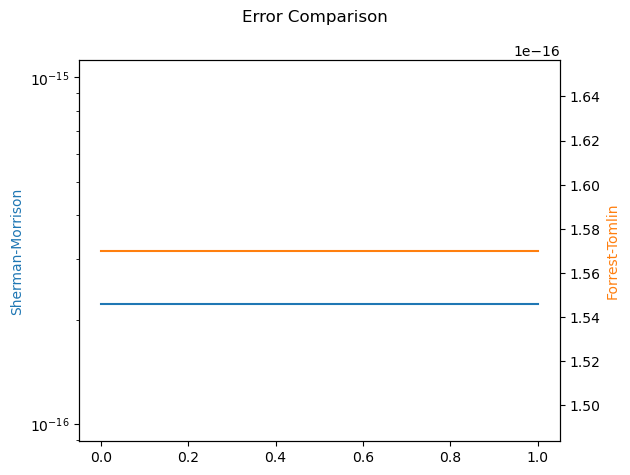

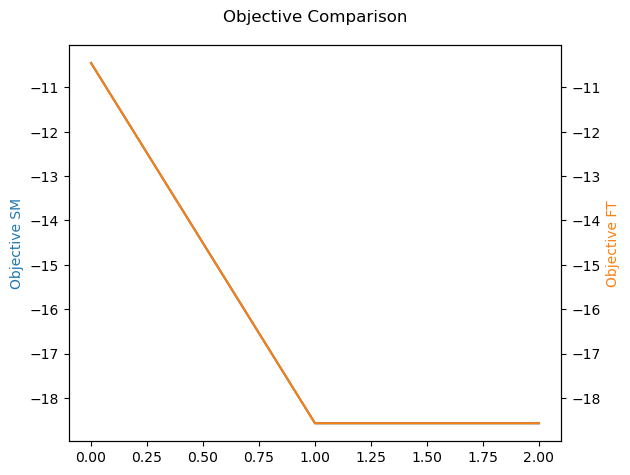

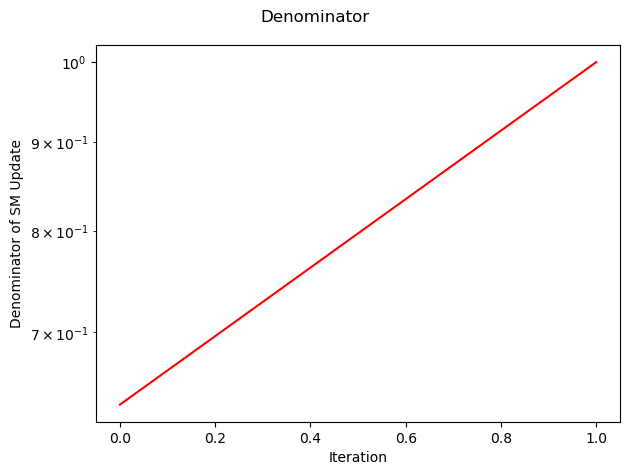

In [24]:
A = np.array([
    [3,2, 1], 
    [3,2, 1], 
    [2, 5, 3],
    [2, 5, 3],
    ])

b = np.array([
    [10], 
    [10], 
    [15],
    [15],
    ])
c = np.array([[-2], [-3], [-4]])
types = ["L","G", "L", "G"]

#actual = -18.571428571428573
x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 10, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 10, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")
print(f"{error_in=}")
print(f"{error_lu=}")
fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('Sherman-Morrison', color='C0')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax2.set_ylabel('Forrest-Tomlin', color='C1')

fig1.suptitle('Error Comparison')
fig1.tight_layout()

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()


fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()


plt.show()

Optimal found after 1 iterations

Optimal found after 5 iterations
LU Optimal found after 1 iterations

LU Optimal found after 5 iterations
optimal_val_inv=-19.999999999999993
optimal_val_lu=-19.999999999999996


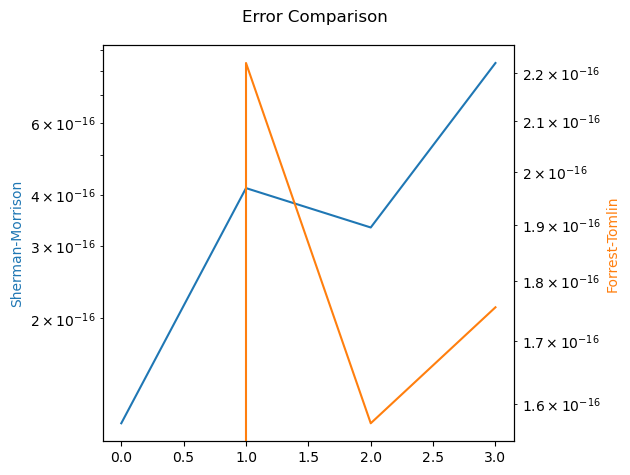

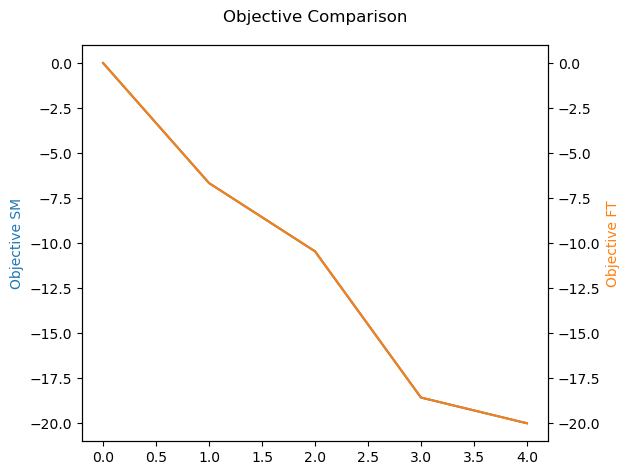

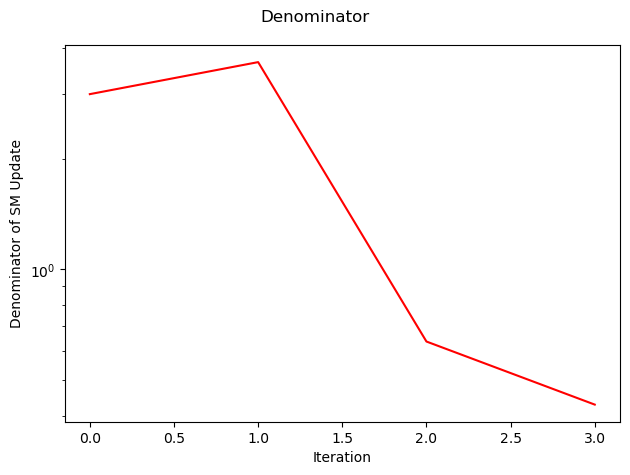

In [25]:
A = np.array([
    [3,2, 1], 
    [2, 5, 3],
    ])

b = np.array([
    [10], 
    [15],
    ])
c = np.array([[-2], [-3], [-4]])
types = ["L","L"]

#actual = -19.999999999999993
x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 10, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 10, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")
# print(f"{error_in=}")
# print(f"{error_lu=}")
fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('Sherman-Morrison', color='C0')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax2.set_ylabel('Forrest-Tomlin', color='C1')
ax2.set_yscale('log')

fig1.suptitle('Error Comparison')
fig1.tight_layout()

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()

plt.show()

Optimal found after 5 iterations

Optimal found after 19 iterations
LU Optimal found after 5 iterations

LU Optimal found after 19 iterations
optimal_val_inv=-464.7531428571429
optimal_val_lu=-464.7531428571426


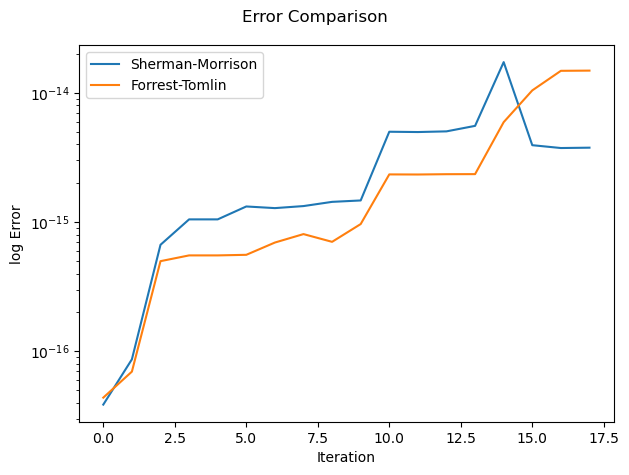

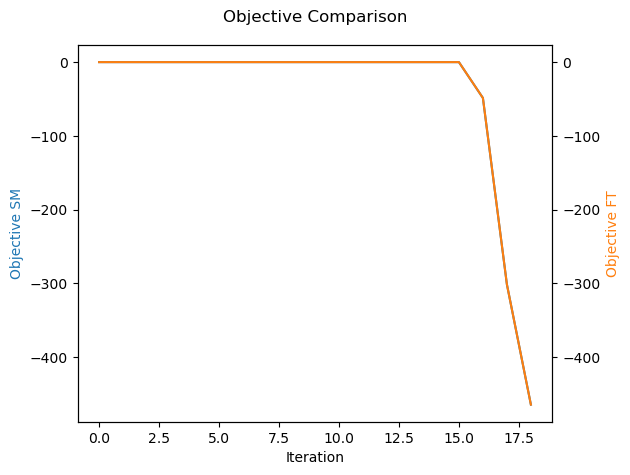

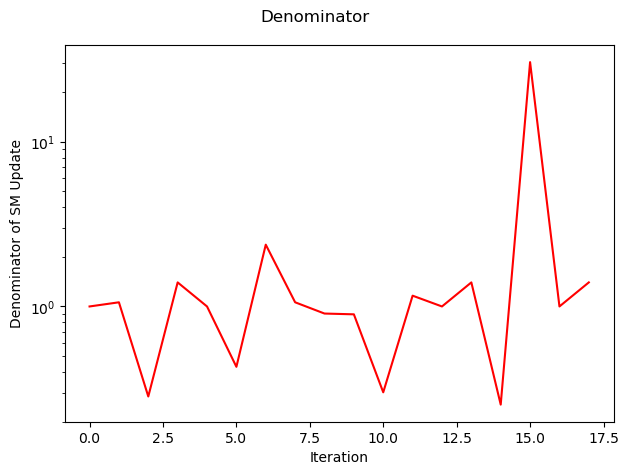

In [26]:
A, b, c, types = load_linear_program(
        r"C:\Users\rejil\Documents\GitHub\LinearProgramming\tests\data\numpy\afiro.mps.npz"
    )

#actual = -464.7531428571429
x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 1000, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 1000, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")

fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('log Error')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')

ax1.plot(error_lu, color='C1', label="Forrest-Tomlin")

# ax2 = ax1.twinx()
# ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
# ax2.set_ylabel('Forrest-Tomlin', color='C1')
# ax2.set_yscale('log')
ax1.legend()
fig1.suptitle('Error Comparison')
fig1.tight_layout()
fig1.savefig("images/error/error_comparison_afiro.jpg", dpi=300)

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
ax3.set_xlabel('Iteration')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()
fig2.savefig("images/objective/objective_afiro.jpg", dpi=300)

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()
fig3.savefig("images/denoms/denoms_afiro.jpg", dpi=300)

plt.show()

Optimal found after 1 iterations

Optimal found after 60 iterations
LU Optimal found after 1 iterations

LU Optimal found after 60 iterations
optimal_val_inv=-64.57507705856447
optimal_val_lu=-64.57507705856452


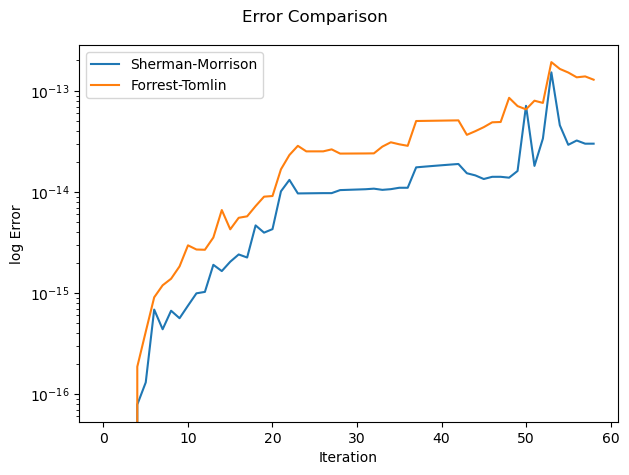

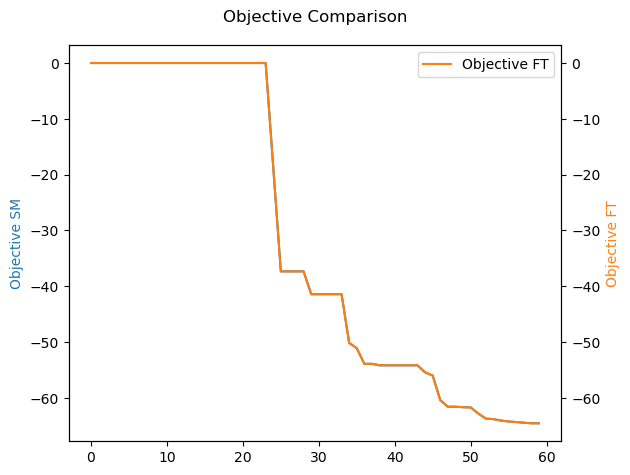

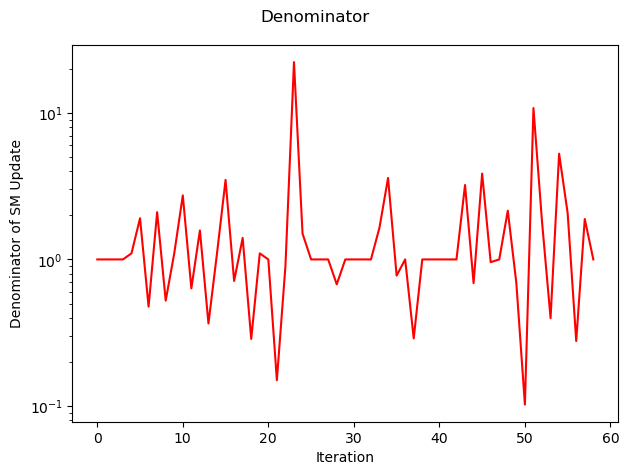

In [27]:
A, b, c, types = load_linear_program(
        r"C:\Users\rejil\Documents\GitHub\LinearProgramming\tests\data\numpy\sc50a.mps.npz"
    )

#actual = -64.57507705856447
x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 1000, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 1000, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")

fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('log Error')
ax1.set_yscale('log')

ax1.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax1.legend()
ax1.set_xlabel('Iteration')
# ax2 = ax1.twinx()
# ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
# ax2.set_ylabel('Forrest-Tomlin', color='C1')
# ax2.set_yscale('log')

fig1.suptitle('Error Comparison')
fig1.tight_layout()
fig1.savefig("images/error/error_comparison_sc50a.jpg", dpi=300)

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')
ax4.set_xlabel('Iteration')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()
fig2.savefig("images/objective/objective_sc50a.jpg", dpi=300)
plt.legend()

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()
fig3.savefig("images/denoms/denoms_sc50a.jpg", dpi=300)

plt.show()

Optimal found after 1 iterations

Optimal found after 67 iterations
LU Optimal found after 1 iterations

LU Optimal found after 67 iterations
optimal_val_inv=-70.0
optimal_val_lu=-70.00000000000001


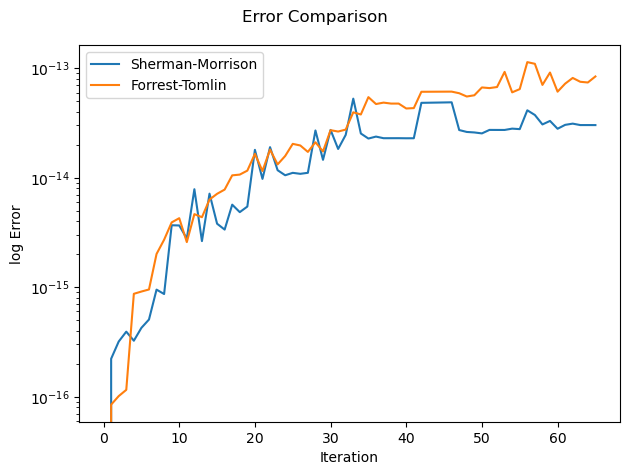

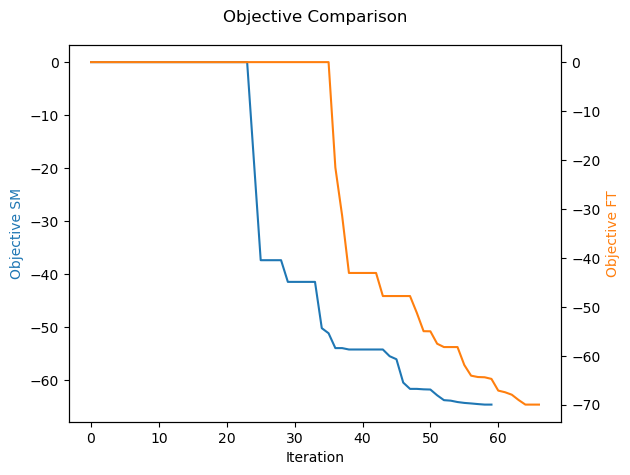

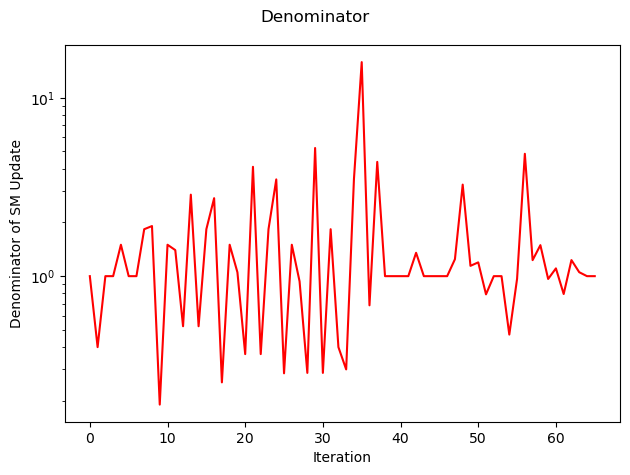

In [28]:
A, b, c, types = load_linear_program(
        r"C:\Users\rejil\Documents\GitHub\LinearProgramming\tests\data\numpy\sc50b.mps.npz"
    )

#actual = -70
x_total_inv, optimal_val_inv, error_in, objective_inv, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 1000, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 1000, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")

fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('log Error')
ax1.set_xlabel('Iteration')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')

ax1.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax1.legend()
# ax2 = ax1.twinx()
# ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
# ax2.set_ylabel('Forrest-Tomlin', color='C1')
# ax2.set_yscale('log')

fig1.suptitle('Error Comparison')
fig1.tight_layout()
fig1.savefig("images/error/error_comparison_sc50b.jpg", dpi=300)

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
ax3.set_xlabel('Iteration')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()
fig2.savefig("images/objective/objective_sc50b.jpg", dpi=300)

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()
fig3.savefig("images/denoms/denoms_sc50b.jpg", dpi=300)

plt.show()

Optimal found after 161 iterations

Optimal found after 151 iterations
LU Optimal found after 161 iterations

LU Optimal found after 151 iterations
optimal_val_inv=225494.9631623794
optimal_val_lu=225494.9631623528


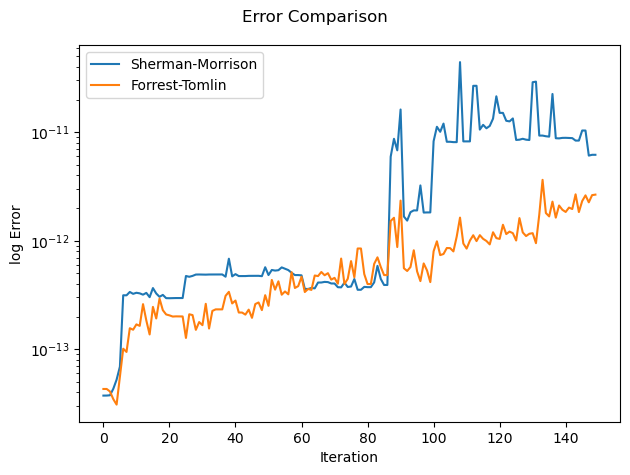

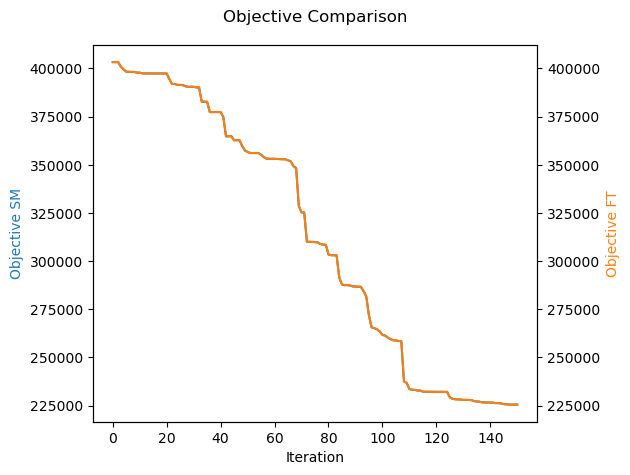

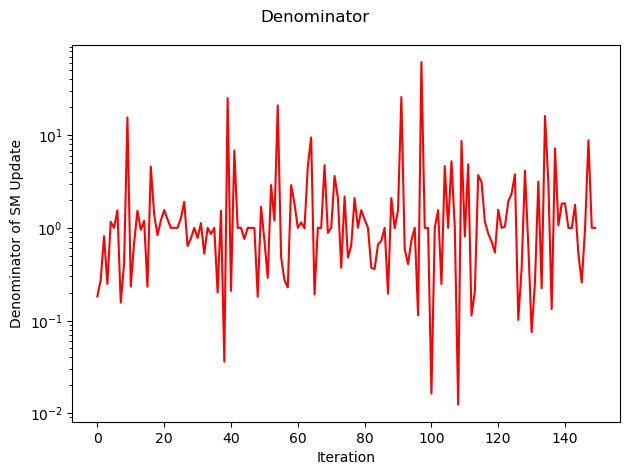

In [29]:
A, b, c, types = load_linear_program(
        r"C:\Users\rejil\Documents\GitHub\LinearProgramming\tests\data\numpy\adlittle.mps.npz"
    )

#actual == 2.2549496316E+05
x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 1000, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 1000, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")

fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('log Error')
ax1.set_xlabel('Iteration')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')

ax1.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax1.legend()
# ax2 = ax1.twinx()
# ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
# ax2.set_ylabel('Forrest-Tomlin', color='C1')
# ax2.set_yscale('log')

fig1.suptitle('Error Comparison')
fig1.tight_layout()
fig1.savefig("images/error/error_comparison_adlittle.jpg", dpi=300)

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
ax3.set_xlabel('Iteration')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()
fig2.savefig("images/objective/objective_adlittle.jpg", dpi=300)

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()
fig3.savefig("images/denoms/denoms_adlittle.jpg", dpi=300)

plt.show()

Optimal found after 1 iterations

Optimal found after 381 iterations
LU Optimal found after 1 iterations

LU Optimal found after 381 iterations
optimal_val_inv=-52.20206121170726
optimal_val_lu=-52.20206121167592


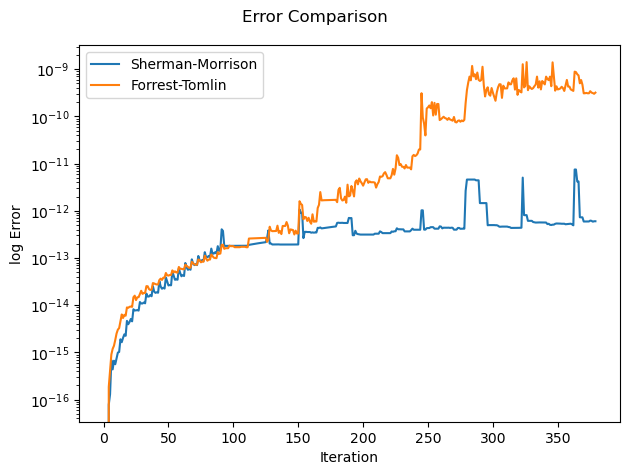

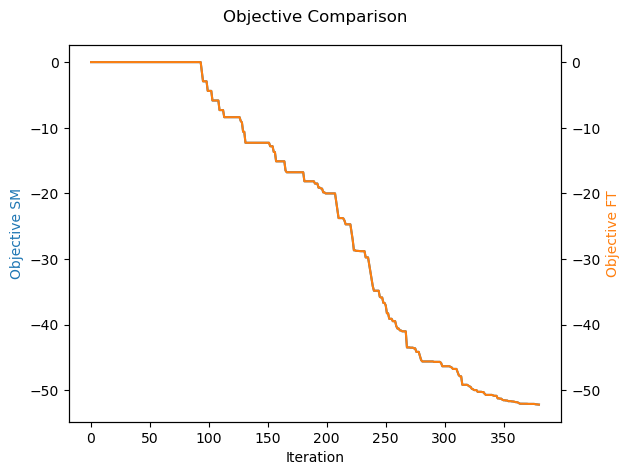

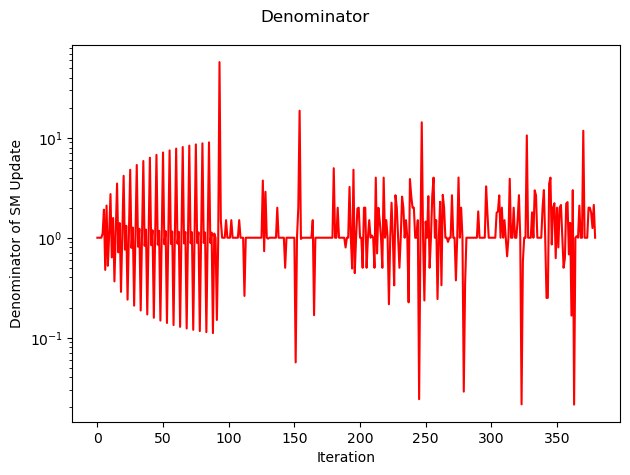

In [30]:
A, b, c, types = load_linear_program(
        r"C:\Users\rejil\Documents\GitHub\LinearProgramming\tests\data\numpy\sc205.mps.npz"
    )
#actual = -5.2202061212E+01
x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 1000, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 1000, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")

fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('log Error')
ax1.set_xlabel('Iteration')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')

ax1.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax1.legend()
# ax2 = ax1.twinx()
# ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
# ax2.set_ylabel('Forrest-Tomlin', color='C1')
# ax2.set_yscale('log')

fig1.suptitle('Error Comparison')
fig1.tight_layout()
fig1.savefig("images/error/error_comparison_sc205.jpg", dpi=300)

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

ax3.set_xlabel('Iteration')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()
fig2.savefig("images/objective/objective_sc205.jpg", dpi=300)

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()
fig3.savefig("images/denoms/denoms_sc205.jpg", dpi=300)

plt.show()

Optimal found after 172 iterations

Optimal found after 130 iterations
LU Optimal found after 172 iterations

LU Optimal found after 118 iterations
optimal_val_inv=-415.7322407404136
optimal_val_lu=-415.73224074141444


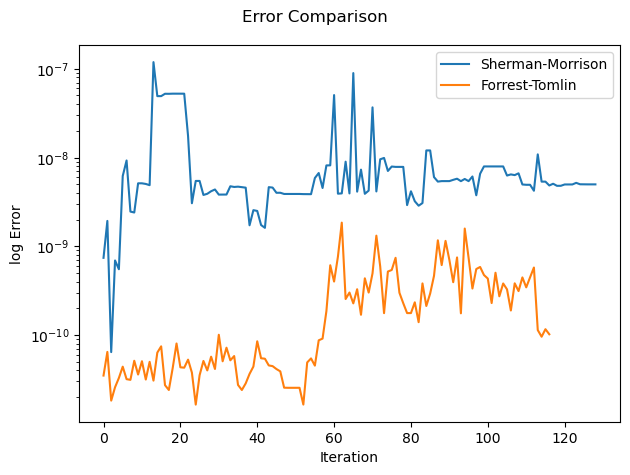

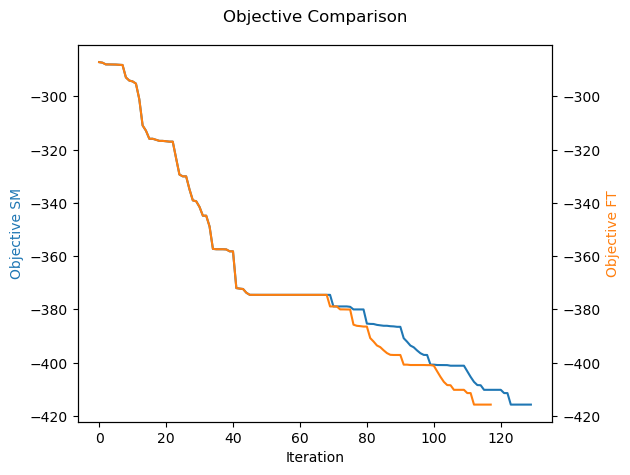

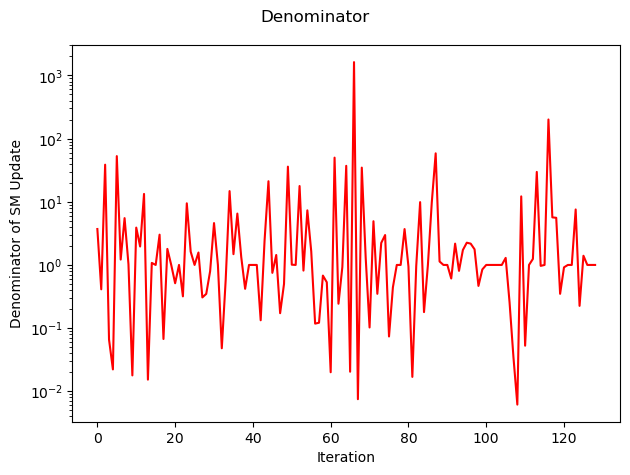

In [31]:
A, b, c, types = load_linear_program(
        r"C:\Users\rejil\Documents\GitHub\LinearProgramming\tests\data\numpy\share2b.mps.npz"
    )

x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-10, 1000, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-10, 1000, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")

fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('log Error')
ax1.set_xlabel('Iteration')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')

ax1.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax1.legend()
# ax2 = ax1.twinx()
# ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
# ax2.set_ylabel('Forrest-Tomlin', color='C1')
# ax2.set_yscale('log')

fig1.suptitle('Error Comparison')
fig1.tight_layout()
fig1.savefig("images/error/error_comparison_share2b.jpg", dpi=300)

fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
ax3.set_xlabel('Iteration')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()
fig2.savefig("images/objective/objective_share2b.jpg", dpi=300)

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()
fig3.savefig("images/denoms/denoms_share2b.jpg", dpi=300)


plt.show()

Optimal found after 38 iterations

Optimal found after 599 iterations
LU Optimal found after 38 iterations

LU Optimal found after 598 iterations
optimal_val_inv=-896644.8254340703
optimal_val_lu=-896644.8218611549


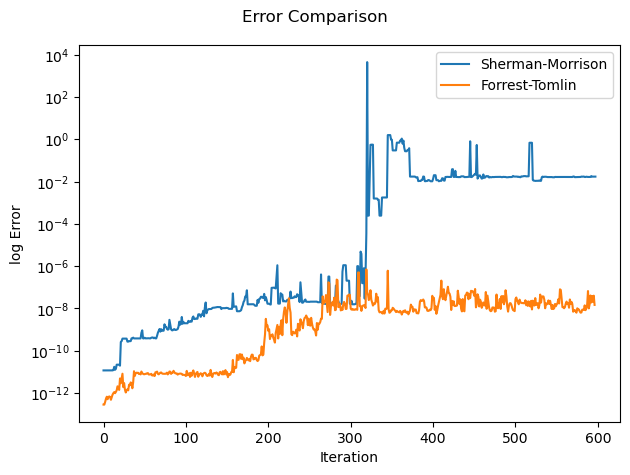

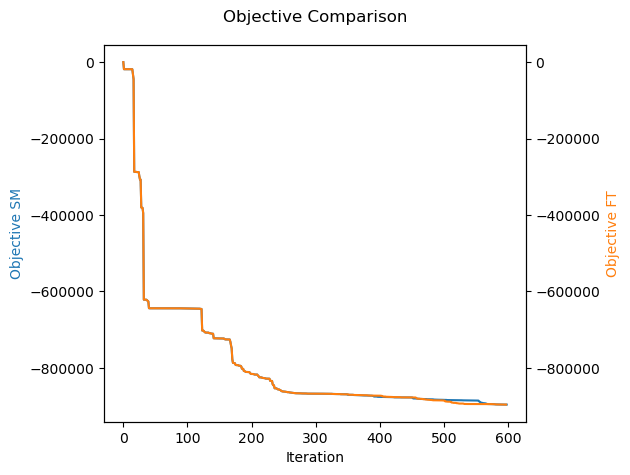

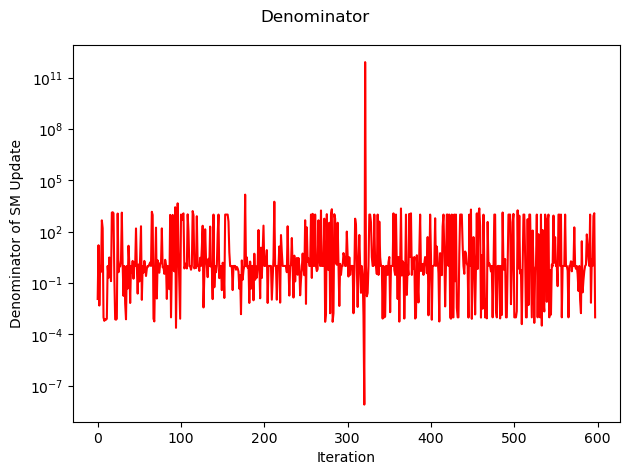

In [33]:
A, b, c, types = load_linear_program(
        r"C:\Users\rejil\Documents\GitHub\LinearProgramming\tests\data\numpy\israel.mps.npz"
    )

x_total_inv, optimal_val_inv, error_in, objective_in, denoms = (revised_simplex_two_phase_inv(A, b, c, types, 1e-9, 1000, "min"))
x_total_lu, optimal_val_lu, error_lu, objective_lu = (revised_simplex_two_phase_lu(A, b, c, types, 1e-9, 1000, "min"))

print(f"{optimal_val_inv=}")
print(f"{optimal_val_lu=}")

fig1, ax1 = plt.subplots()


ax1.plot(error_in, color='C0', label="Sherman-Morrison")
ax1.set_ylabel('log Error')
ax1.set_xlabel('Iteration')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')

ax1.plot(error_lu, color='C1', label="Forrest-Tomlin")
ax1.legend()
# ax2 = ax1.twinx()
# ax2.plot(error_lu, color='C1', label="Forrest-Tomlin")
# ax2.set_ylabel('Forrest-Tomlin', color='C1')
# ax2.set_yscale('log')

fig1.suptitle('Error Comparison')
fig1.tight_layout()
fig1.savefig("images/error/error_comparison_israel.jpg", dpi=300)


fig2, ax3 = plt.subplots()


ax3.plot(objective_in, color='C0', label="Objective SM")
ax3.set_ylabel('Objective SM', color='C0')
ax3.set_xlabel('Iteration')
# ax3.set_yscale('log')

ax4 = ax3.twinx()
ax4.plot(objective_lu, color='C1', label="Objective FT")
ax4.set_ylabel('Objective FT', color='C1')

fig2.suptitle('Objective Comparison')
fig2.tight_layout()
fig2.savefig("images/objective/objective_israel.jpg", dpi=300)

fig3, ax5 = plt.subplots()
ax5.plot(denoms, color='red')
ax5.set_yscale('log')
ax5.set_ylabel('Denominator of SM Update')
ax5.set_xlabel('Iteration')
fig3.suptitle('Denominator')
fig3.tight_layout()
fig3.savefig("images/denoms/denoms_israel.jpg", dpi=300)


plt.show()
#.9664482186

In [ ]:
n = 10
for i in range(1000):
    A = np.random.rand(n,n)
    P, L, U = lu(A)
    assert np.allclose(A, P @ L @ U, rtol=GLOBAL_TOLERANCE, atol=GLOBAL_TOLERANCE)